<a href="https://colab.research.google.com/github/DiploDatos/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2022

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](images/sarsa.png)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](images/q_learning.png)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [34]:
#@title Código básico de graficación (no modificar)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)
    

def reward_per_episode(reward_ep):
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]
    return reward_per_episode

def steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    return episode_steps

def steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]
    return steps_per_episode 

Ejemplo: agente CartPole

In [35]:
import gym
import time
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    for _ in range(500):
        env.render(mode='human')
        observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [36]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    observation = env.reset()
    for t in range(500):
        env.render(mode='human')
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [37]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria

    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [57]:
def learn(state, action, reward, next_state, next_action):
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [38]:
def run(on_policy):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            
            if(on_policy):
                learnSARSA(state, action, reward, next_state, next_action)
            else:
                learnQ(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [55]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [58]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

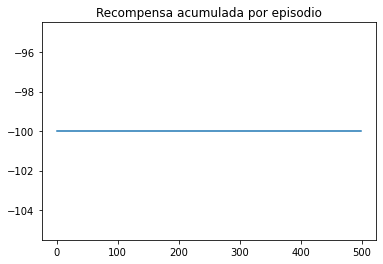

In [59]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

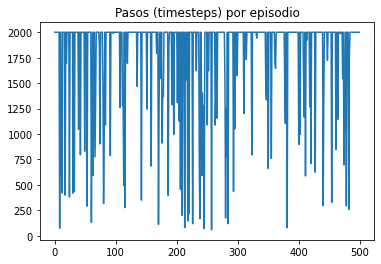

In [60]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

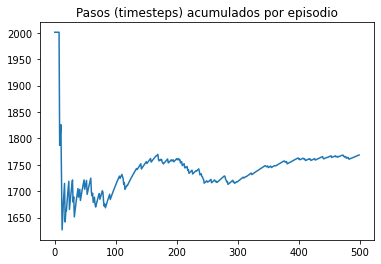

In [61]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

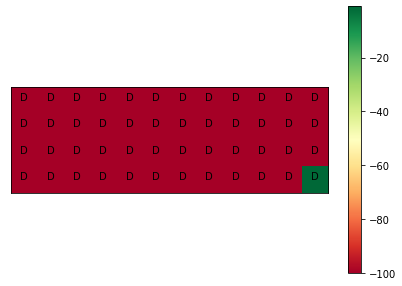


 Matriz de mejor acción-valor (en números): 

 [[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [62]:
draw_value_matrix(q)

In [63]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN

### 1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

In [39]:
def learnSARSA(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    actual_q = q.get((state, action),0.0)
    update = reward + gamma * q.get((next_state, next_action),0.0) 
    q[(state,action)] = actual_q + alpha*(update-actual_q)
    pass

In [40]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [41]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(on_policy = True)

La recompensa promedio por episodios fue de -28.076


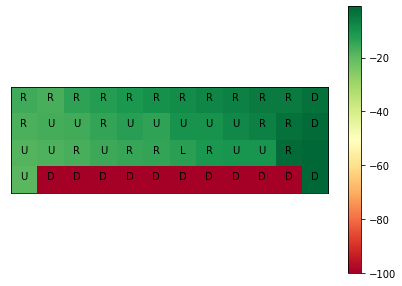


 Matriz de mejor acción-valor (en números): 

 [[ -15.76652364  -17.14445983  -13.44809168  -12.37480819  -11.08181068
    -9.8262913    -8.57881676   -7.35461484   -6.17705781   -5.06785294
    -5.18906552   -3.05607374]
 [ -17.59343687  -16.82997746  -16.20848431  -14.39343136  -12.64235228
   -13.9388072   -10.23282962  -10.17677389   -7.83280342   -6.2760716
    -3.00578309   -2.00043808]
 [ -18.60836299  -17.77055318  -17.07240579  -15.51036454  -14.79096411
   -14.47074734  -13.11067971  -11.20785794  -10.43309233  -10.56659785
    -2.00000003   -1.        ]
 [ -19.41155811 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [42]:
reward_per_episode_SARSA = reward_per_episode(reward_ep)
steps_per_episode_SARSA = steps_per_episode(timesteps_ep)
steps_per_episode_smooth_SARSA = steps_per_episode_smooth(timesteps_ep)
print(f'La recompensa promedio por episodios fue de {avg_steps_per_episode}')
draw_value_matrix(q)

### 2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

In [43]:
def learnQ(state, action, reward, next_state, next_action):
    """
    Q-learm update for a given state transition
    """
    # TODO - completa con tu código aquí
    actual_q = q.get((state, action),0.0)
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_values)
    update = reward + gamma * max_q #La politica optima de la tabla q para esa accion 
    q[(state,action)] = actual_q + alpha * (update-actual_q)
    pass


In [44]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [45]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(on_policy = False)

El numero de recompensa promedio por episodios fue de -38.232


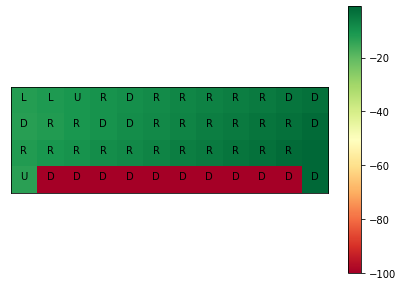


 Matriz de mejor acción-valor (en números): 

 [[ -12.32630844  -11.6898064   -10.82575017  -10.15575912   -9.24836831
    -8.4240978    -7.52882669   -6.63160139   -5.7820478    -4.89281475
    -3.94213919   -2.9970403 ]
 [ -12.90308185  -11.98481297  -10.99464723   -9.99936767   -8.99982185
    -7.99991185   -6.99996603   -5.9999874    -4.99999492   -3.99999902
    -2.99999992   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [46]:
reward_per_episode_Q = reward_per_episode(reward_ep)
steps_per_episode_Q = steps_per_episode(timesteps_ep)
steps_per_episode_smooth_Q = steps_per_episode_smooth(timesteps_ep)
print(f'El numero de recompensa promedio por episodios fue de {avg_steps_per_episode}')
draw_value_matrix(q)

### Analisis de convergencia Q-Learning vs SARSA

Text(0, 0.5, 'Steps')

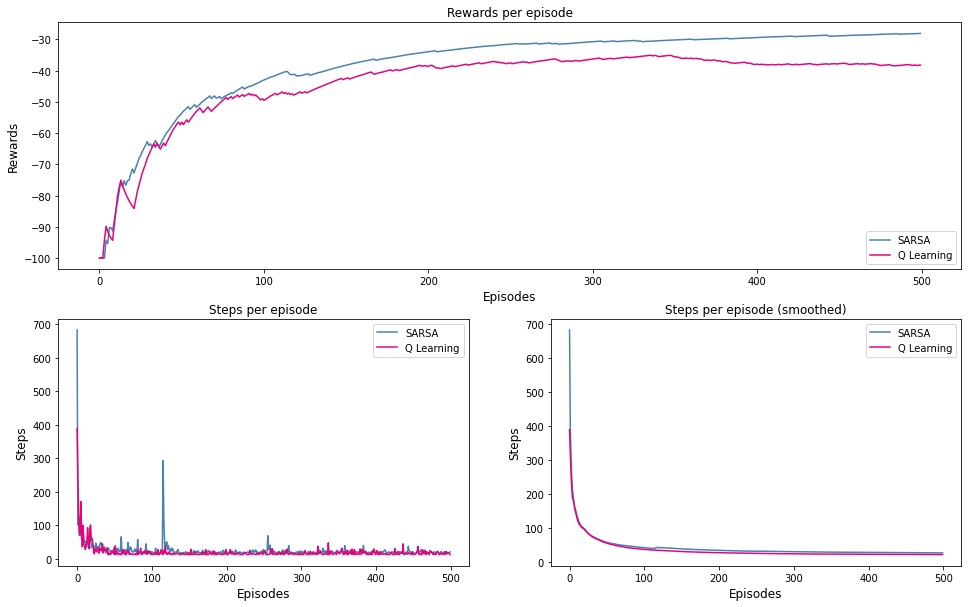

In [48]:
fig = plt.figure(figsize=((10*1.618),10))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))


ax1.plot(reward_per_episode_SARSA, color = 'steelblue', label= 'SARSA')
ax1.plot(reward_per_episode_Q, color = '#e4047d', label= 'Q Learning')
ax1.legend(loc = 'lower right')
ax1.set_title("Rewards per episode")
ax1.set_xlabel("Episodes", size = 12)
ax1.set_ylabel("Rewards", size = 12)


ax2.plot(steps_per_episode_SARSA, color = 'steelblue', label= 'SARSA')
ax2.plot(steps_per_episode_Q, color = '#e4047d', label= 'Q Learning')
ax2.legend(loc = 'upper right')
ax2.set_title("Steps per episode")
ax2.set_xlabel("Episodes", size = 12)
ax2.set_ylabel("Steps", size = 12)

ax3.plot(steps_per_episode_smooth_SARSA, color = 'steelblue', label= 'SARSA')
ax3.plot(steps_per_episode_smooth_Q, color = '#e4047d', label= 'Q Learning')
ax3.legend(loc = 'upper right')
ax3.set_title("Steps per episode (smoothed)")
ax3.set_xlabel("Episodes", size = 12)
ax3.set_ylabel("Steps", size = 12)

- Se puede observar en el primer grafico la peformance de ambos metodos. De forma un poco contraintuitiva el algoritmo Q-Learning obtiene una menor recompensa por episodio que el SARSA a pesar de que el primero esta diseñado con la finalidad de maximizar la recompensa. Esta peor performance se debe al uso de una seleccion de accion basada en $\epsilon$-greddy. Despues del transitorio el algoritmo Q-learning aprende el camino optimo, que es el que esta en la orilla del acantilado, pero al tener un margen de exploracion dado por $\epsilon = 0.1$ produce que el agente de vez en cuando se caiga por el acantilado lo cual esta severamente penalizado y repercute en la recompensa obtenida. Por su parte el algoritmo SARSA al basar su politica en la seleccion de accion termina aprendiendo un camino menos optimo pero mas seguro, en este caso la exploracion lo lleva a rodear el acantilado a los fines de mantener una recompensa mas constante.

- El algoritmo SARSA toma en promedio mas pasos por episodio que el Q-Learning, como se observa claramente en los dos graficos inferirores.

In [194]:
env.close()

### 3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

In [173]:
#Defino los parametros en terminos de los rangos numericos
alphas = np.linspace(0,1,21)
gammas = np.linspace(0,1,11)
epsilons = np.linspace(0,1,11)

### Variando $\alpha$ entre 0 y 1.

In [174]:
q = {}

gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [191]:
# Diccionarios que van a almacenar los valores que retorna el run() para los distintos valores de alpha
reward_per_episode_alpha_SARSA = {}
steps_per_episode_alpha_SARSA = {}
reward_per_episode_alpha_Q = {}
steps_per_episode_alpha_Q = {}

for alpha in alphas:
    avg_steps_per_episode_SARSA, timesteps_ep_SARSA, reward_ep_SARSA = run(on_policy = True)
    reward_per_episode_alpha_SARSA[alpha] =  reward_ep_SARSA
    steps_per_episode_alpha_SARSA[alpha] = timesteps_ep_SARSA
    avg_steps_per_episode_Q, timesteps_ep_Q, reward_ep_Q = run(on_policy = False)
    reward_per_episode_alpha_Q[alpha] =  reward_ep_Q
    steps_per_episode_alpha_Q[alpha] = timesteps_ep_Q

### Variando $\gamma$ entre 0 y 1.

In [195]:
q = {}

alpha = 0.5
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [196]:
# Diccionarios que van a almacenar los valores que retorna el run() para los distintos valores de gamma
reward_per_episode_gamma_SARSA = {}
steps_per_episode_gamma_SARSA = {}
reward_per_episode_gamma_Q = {}
steps_per_episode_gamma_Q = {}

for gamma in gammas:
    avg_steps_per_episode_SARSA, timesteps_ep_SARSA, reward_ep_SARSA = run(on_policy = True)
    reward_per_episode_gamma_SARSA[gamma] =  reward_ep_SARSA
    steps_per_episode_gamma_SARSA[gamma] = timesteps_ep_SARSA
    avg_steps_per_episode_Q, timesteps_ep_Q, reward_ep_Q = run(on_policy = False)
    reward_per_episode_gamma_Q[gamma] =  reward_ep_Q
    steps_per_episode_gamma_Q[gamma] = timesteps_ep_Q

### Variando $\epsilon$ entre 0 y 1.

In [198]:
q = {}

alpha = 0.5
gamma = 1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [ ]:
reward_per_episode_epsilon_SARSA = {}
steps_per_episode_epsilon_SARSA = {}
reward_per_episode_epsilon_Q = {}
steps_per_episode_epsilon_Q = {}
for epsilon in epsilons:
    avg_steps_per_episode_SARSA, timesteps_ep_SARSA, reward_ep_SARSA = run(on_policy = True)
    reward_per_episode_epsilon_SARSA[epsilon] =  reward_ep_SARSA
    steps_per_episode_epsilon_SARSA[epsilon] = timesteps_ep_SARSA
    avg_steps_per_episode_Q, timesteps_ep_Q, reward_ep_Q = run(on_policy = False)
    reward_per_episode_epsilon_Q[epsilon] =  reward_ep_Q
    steps_per_episode_epsilon_Q[epsilon] = timesteps_ep_Q

In [ ]:
env.close()

### 4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

In [28]:
def choose_action_soft_max(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    num_soft_max = [np.exp(q/tau) for q in q_values]
    den_soft_max = np.sum(num_soft_max)

    if  den_soft_max == 0:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria
    else:
        soft_max = [num_soft_max/den_soft_max for n in num_soft_max]
        
    max_soft_max = max(soft_max) 
    count = sum(map(lambda q : q == max_soft_max, soft_max))

    
    # hay más de un máximo valor de estado-acción?
    if len(count) > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if soft_max[i] == max_soft_max]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = soft_max.index(max_soft_max)

    return actions[i]

In [26]:
def run_soft_max(on_policy):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action_soft_max(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action_soft_max(nex_state)
            

            episode_reward += reward
            
            if(on_policy):
                learnSARSA(state, action, reward, next_state, next_action)
            else:
                learnQ(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [23]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(123)

In [29]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_soft_max(on_policy = False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
reward_per_episode_SARSA = reward_per_episode(reward_ep)
steps_per_episode_SARSA = steps_per_episode(timesteps_ep)
steps_per_episode_smooth_SARSA = steps_per_episode_smooth(timesteps_ep)
print(f'La recompensa promedio por episodios fue de {avg_steps_per_episode}')
draw_value_matrix(q)